In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.signal import medfilt, butter, filtfilt, find_peaks
import scipy.io

In [6]:
# params
fs = 250
window_len_sec = 10
plot_window_sec = 60

In [28]:
mat_data = scipy.io.loadmat("ecg.mat")
print("Kyes in file:", mat_data.keys())

signal = mat_data["ecg118e00"]
signal = signal[:, 0]
signal

Kyes in file: dict_keys(['__header__', '__version__', '__globals__', 'ecg118e00'])


array([-5.955, -5.955, -5.955, ...,  1.12 ,  1.175, -3.95 ],
      shape=(650000,))

In [29]:
baseline = medfilt(signal, kernel_size=201)
signal_detrended = signal - baseline

In [49]:
from scipy.signal import butter, filtfilt

def bandstop_filter(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return filtfilt(b, a, data)

# Banspass filter was added, because there was still noise
def bandpass_filter(data, lowcut=5, highcut=15, fs=250, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return filtfilt(b, a, data)

In [50]:
signal_filtered = bandstop_filter(signal_detrended, 48, 52, fs)
signal_filtered = bandpass_filter(signal_filtered)

In [51]:
min_distance = int(0.3 * fs)
peak_height = 0.2 * np.max(signal_filtered)

peaks, properties = find_peaks(signal_filtered, height=peak_height, distance=min_distance)


rr_intervals = np.diff(peaks) / fs

def compute_hrv(rr_ints):
    if len(rr_ints) < 2:
        return None
    hr = 60 / np.mean(rr_ints)
    sdnn = np.std(rr_ints) 
    rmssd = np.sqrt(np.mean(np.diff(rr_ints)**2))
    diff_rr = np.abs(np.diff(rr_ints))
    nn50 = np.sum(diff_rr > 0.05)
    pnn50 = (nn50 / len(diff_rr)) * 100 if len(diff_rr) > 0 else 0
    return {"HR": hr, "SDNN": sdnn, "RMSSD": rmssd, "NN50": nn50, "pNN50": pnn50}

num_samples_window = window_len_sec * fs
hrv_results = []
for start in range(0, len(signal_filtered), num_samples_window):
    end = start + num_samples_window
    window_peaks = peaks[(peaks >= start) & (peaks < end)]
    if len(window_peaks) > 1:
        rr_window = np.diff(window_peaks) / fs
        hrv = compute_hrv(rr_window)
        hrv_results.append((start/fs, hrv))
    else:
        hrv_results.append((start/fs, None))

In [52]:
print("HRV summary per 10-second window:\n")

for t, hrv in hrv_results:
    print(f"Window starting at {int(t)}s:")
    if hrv is not None:
        print(f"  HR: {hrv['HR']:.1f} BPM")
        print(f"  SDNN: {hrv['SDNN']:.3f} s")
        print(f"  RMSSD: {hrv['RMSSD']:.3f} s")
        print(f"  NN50: {hrv['NN50']}")
        print(f"  pNN50: {hrv['pNN50']:.1f} %\n")
    else:
        print("  Not enough R peaks for HRV calculation.\n")

HRV summary per 10-second window:

Window starting at 0s:
  HR: 49.9 BPM
  SDNN: 0.018 s
  RMSSD: 0.020 s
  NN50: 0
  pNN50: 0.0 %

Window starting at 10s:
  HR: 49.6 BPM
  SDNN: 0.027 s
  RMSSD: 0.037 s
  NN50: 1
  pNN50: 16.7 %

Window starting at 20s:
  HR: 51.4 BPM
  SDNN: 0.017 s
  RMSSD: 0.015 s
  NN50: 0
  pNN50: 0.0 %

Window starting at 30s:
  HR: 50.7 BPM
  SDNN: 0.031 s
  RMSSD: 0.034 s
  NN50: 1
  pNN50: 14.3 %

Window starting at 40s:
  HR: 42.5 BPM
  SDNN: 0.430 s
  RMSSD: 0.722 s
  NN50: 2
  pNN50: 40.0 %

Window starting at 50s:
  HR: 51.7 BPM
  SDNN: 0.039 s
  RMSSD: 0.029 s
  NN50: 1
  pNN50: 14.3 %

Window starting at 60s:
  HR: 49.9 BPM
  SDNN: 0.030 s
  RMSSD: 0.020 s
  NN50: 0
  pNN50: 0.0 %

Window starting at 70s:
  HR: 49.1 BPM
  SDNN: 0.013 s
  RMSSD: 0.009 s
  NN50: 0
  pNN50: 0.0 %

Window starting at 80s:
  HR: 49.6 BPM
  SDNN: 0.017 s
  RMSSD: 0.029 s
  NN50: 0
  pNN50: 0.0 %

Window starting at 90s:
  HR: 50.3 BPM
  SDNN: 0.014 s
  RMSSD: 0.022 s
  NN50: 

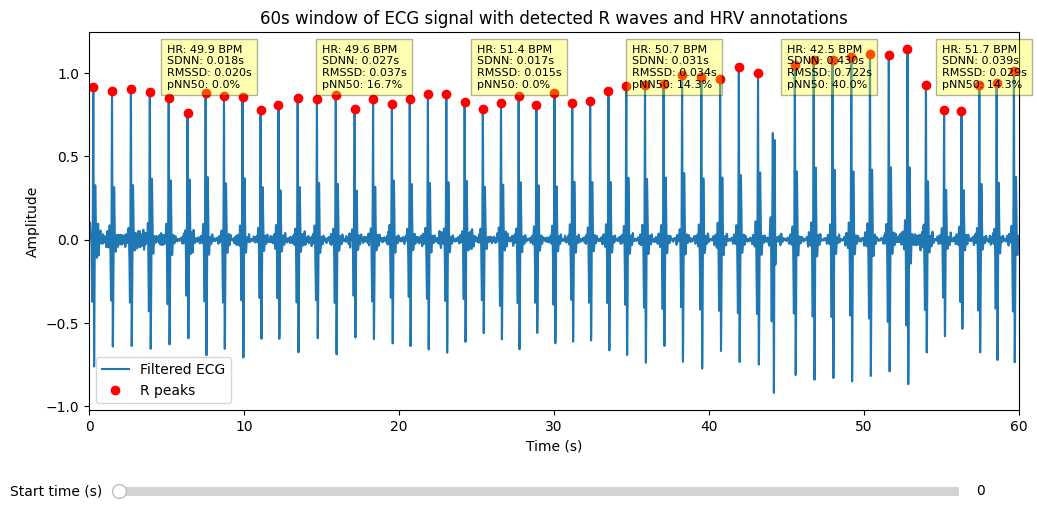

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(bottom=0.25)
time = np.arange(len(signal_filtered)) / fs

def update_plot(start_time):
    start_idx = int(start_time * fs)
    end_idx = start_idx + int(plot_window_sec * fs)
    ax.clear()
    ax.plot(time[start_idx:end_idx], signal_filtered[start_idx:end_idx], label="Filtered ECG")

    window_peaks = peaks[(peaks >= start_idx) & (peaks < end_idx)]
    ax.plot(time[window_peaks], signal_filtered[window_peaks], "ro", label="R peaks")

    for window_start_sec, hrv in hrv_results:
        if start_time <= window_start_sec < start_time + plot_window_sec:
            if hrv is not None:
                pos = window_start_sec + window_len_sec/2
                txt = f"HR: {hrv['HR']:.1f} BPM\nSDNN: {hrv['SDNN']:.3f}s\nRMSSD: {hrv['RMSSD']:.3f}s\npNN50: {hrv['pNN50']:.1f}%"
                ax.text(pos, np.max(signal_filtered[start_idx:end_idx])*0.8, txt,
                        fontsize=8, bbox=dict(facecolor='yellow', alpha=0.3))

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title("60s window of ECG signal with detected R waves and HRV annotations")
    ax.legend()
    ax.set_xlim(time[start_idx], time[end_idx])
    plt.draw()

init_start = 0
update_plot(init_start)

ax_slider = plt.axes([0.15, 0.1, 0.7, 0.03])
slider = Slider(ax_slider, 'Start time (s)', 0, (len(signal_filtered)/fs - plot_window_sec),
                valinit=init_start, valstep=1)

def slider_update(val):
    update_plot(val)

slider.on_changed(slider_update)

plt.show()